# Homework 1

### Deadline: Monday 24 March 2024 (by 19h00)

### Credits: 20 points

### Instructions:

- When you finish, please submit a single **.ipynb** file via email to wbanda@yachaytech.edu.ec


- The homework is **individual**. Please include your name in the notebook.


- Within a **single python notebook**, solve the following problems.

# Name: Males-Araujo Yorlan

## 1. Population dynamics (8 points)

The system of ordinary differential equations (ODEs) describing the population dynamics of two prey species ($x$ and $y$) and one predator species ($z$) is given by:


\begin{aligned}
\frac{dx}{dt} &= g_1\,x \left( 1 - \frac{x}{c_1} \right) - p_1\,x\,z, \\
\frac{dy}{dt} &= g_2\,y \left( 1 - \frac{y}{c_2} \right) - p_2\,y\,z, \\
\frac{dz}{dt} &= e_1\,p_1\,x\,z + e_2\,p_2\,y\,z - d\,z.
\end{aligned}


where:

- $g_1$, $g_2$ are the intrinsic growth rates (e.g. birth rates) of the prey populations,

- $c_1$, $c_2$ are the carrying capacities of the prey populations (the carrying capacity of an environment is the maximum population size of a biological species that can be sustained by that specific environment), 
  
- $p_1$, $p_2$ are the predation rates of the predator on each prey (e.g. how successful a hunt is),

- $e_1$, $e_2$ are the conversion efficiencies of consumed prey into predator biomass (the conversion efficiency tells us how efficiently a predator can use the energy from its prey to reproduce),

- $d$ is the natural death rate of the predator. Note that the death rates of the two prey species are intrinsically given by their individual carrying capacities.

This system models the interactions where both prey species grow logistically but are consumed by a common predator.

In [1]:
# Libraries
import os
import time
import glob
import warnings

import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

import scienceplots
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Image as IPImage

---
**On the plot style**

The style I used requires $\LaTeX$ along with some additional fonts. They can be easily installed with:


```bash
sudo apt-get install texlive-fonts-recommended texlive-fonts-extra
```


There should not be problems, but, if so, please comment the line below. I really liked the final results.

---

In [2]:
# Set plot style
plt.style.use(['science', 'nature', 'high-vis'])

### State vector and slope:

#### **(a)** Write down this system of ODEs in terms of the system state vector $S(t)$, i.e. $\frac{dS}{dt} = F(S)$. Identify the slope function $F(S)$ and indicate whether or not it can be explicitly written as a function of $S$. Create a python function for the slope $F(S)$.

Taking the state vector as $S(t) = [x(t), y(t), z(t)]^{\top}$, the system of ODEs can be written as:

\begin{aligned}
\frac{dS}{dt} = F(S) = \begin{bmatrix}
g_1\,x \left( 1 - \displaystyle\frac{x}{c_1} \right) - p_1\,x\,z \\[1.2em]
g_2\,y \left( 1 - \displaystyle\frac{y}{c_2} \right) - p_2\,y\,z \\[1.2em]
e_1\,p_1\,x\,z + e_2\,p_2\,y\,z - d\,z
\end{bmatrix},
\end{aligned}

which is practically the same as the original system. **The slope function $F(S)$ can be explicitly written as a function of $S$.**

In [3]:
# We now create the slope function
def slope(t, S, params):
    """
    Slope of the ODE system.

    Parameters
    ----------
    t : float
        The time (not used).
    s : np.ndarray
        State vector, [x y z].
    params : dict
        All the system parameters.

    Returns
    -------
    np.ndarray
        The slope array.
    """
    # Get the state variables
    x, y, z = S

    # Get the parameters
    g1 = params['g1']
    c1 = params['c1']
    p1 = params['p1']
    g2 = params['g2']
    c2 = params['c2']
    p2 = params['p2']
    e1 = params['e1']
    e2 = params['e2']
    d = params['d']

    # Compute the slope
    dx_dt = g1*x*(1 - x/c1) - p1*x*z
    dy_dt = g2*y*(1 - y/c2) - p2*y*z
    dz_dt = e1*p1*x*z + e2*p2*y*z - d*z
    
    return np.array([dx_dt, dy_dt, dz_dt])

### ODE integration methods:

#### **(b)** Create a python function that implements a trapezoidal Euler method for ODE integration.

The trapezoidal Euler method is given by

\begin{aligned}
S(t_{i+1})= S(t_i) + \frac{h}{2}\left(k_1 + k_2\right),
\end{aligned}

where $k_1 = F(t_i, S(t_i))$, $k_2 = F(t_i + h, S(t_i) + h\,k_1)$, and $h$ is the step size. *The method is of implicit type*.

In [4]:
def trapezoidal(slope_func, t_span, s0, h, params):
    """
    It integrates an ODE system using the trapezoidal method.

    Parameters
    ----------
    slope_func : callable
        The slope function.
    t_span : tuple
        Start and stop time.
    s0 : np.ndarray
        The initial conditions.
    h : float
        The step size.
    params : dict
        The system parameters.

    Returns
    -------
    np.ndarray
        The time vector.
    np.ndarray
        The state vector.
    """
    # Determine the number of steps
    t0, tf = t_span
    steps = int((tf - t0)/h)

    # Initialize the time and state vectors
    t = np.linspace(t0, tf, steps + 1)
    S = np.zeros((steps + 1, len(s0)))

    # Set the initial conditions
    S[0] = s0

    # Integrate the system
    for i in range(0, steps):
        
        # Compute the slopes
        k1 = slope_func(t[i], S[i], params)
        k2 = slope_func(t[i] + h, S[i] + h*k1, params)

        # Update the state vector
        S[i + 1] = S[i] + h*(k1 + k2)/2

    return t, S

#### **(c)** Design your own third-order RK method (RK3), and create a python function for this integrator.

---
**Approach**

We are going to use the **Butcher tableau** representation because it's nice and compact. 

Now, we want to create an explicit RK3 method with three stages. The empty Butcher tableau for such method has the form:

\begin{array}{c|ccc}
0 & 0 & 0 & 0 \\[0.7em]
c_1 & a_{10} & 0 & 0 \\[0.7em]
c_2 & a_{20} & a_{21} & 0 \\[0.7em]
\hline
& b_0 & b_1 & b_2
\end{array}

where $c_i$ are the nodes (where the function is evaluated), $a_{ij}$ are the weights (the coefficients of the method), and $b_i$ are the weights of the final combination.


**Set of conditions to satisfy**

In order for it to be a third-order method, we need to fulfill the following conditions $[1]$:

1. Order $1$ condition: 
$$
\sum_{i=1}^{s} b_i = 1,
$$

2. Order $2$ condition:
$$
\sum_{i=1}^{s} b_i c_i = \frac{1}{2},
$$

3. Order $3$ conditions:
$$
\sum_{i=1}^{s} b_i c_i^2 = \frac{1}{3},
$$
$$
\sum_{i=1}^{s} b_i\sum_{j=1}^{i-1} a_{ij} c_j = \frac{1}{6}.
$$

**Proposed method**

Having set $c_2 = 1$, our Butcher tableau, in terms of $c_1$, is:

\begin{array}{c|ccc}
0 & 0 & 0 & 0 \\[1em]
c_1 & c_1 & 0 & 0 \\[1em]
c_2 & 1 - \displaystyle\frac{1 - c_1}{c_1(2 - 3c_1)} & \displaystyle\frac{1 - c_1}{c_1(2 - 3c_1)} & 0 \\[1em]
\hline
& 1 - \displaystyle\frac{1 - c_1}{c_1(2 - 3c_1)} & \displaystyle\frac{1}{6c_1(1 - c_1)} & \displaystyle\frac{1}{3} - \displaystyle\frac{c_1}{6(1 - c_1)}
\end{array}

Note that solutions are valid as long as $c_1 \neq 0$, $c_1 \neq 1$ and $c_1 \neq 2/3$ to avoid division by zero, and that the parameter $c_1$ is left to choice.

**Reference:**

- $[1]$ This [PDF](https://sceweb.uhcl.edu/feagin/courses/rungekutta.pdf). It also provided hints for the derivation.

---


In [5]:
# ------------- Method parameters -------------

# Nodes
c0 = 0
c1 = np.pi/6 # Any but 0, 1, or 2/3
c2 = 1

# Matrix coefficients
a10 = c1
a21 = (1 - c1)/(c1 * (2 - 3*c1))
a20 = 1 - a21

# Final weights
b1 = 1 / (6 * c1 * (1 - c1))
b2 = 1 / 3 - c1 / (6 * (1 - c1)) 
b0 = 1 - b2 - b1

# --------------- Verification ---------------

# Determine if they are close to the expected values
cond_1 = np.isclose(b0 + b1 + b2, 1)
cond_2 = np.isclose(b0 * c0 + b1 * c1 + b2 * c2, 1/2)
cond_3a = np.isclose(b0*c0**2 + b1*c1**2 + b2*c2**2, 1/3)
cond_3b = np.isclose(b2 * a21 * c1, 1/6)

# Print results
if all([cond_1, cond_2, cond_3a, cond_3b]):
    print('All conditions are satisfied :)!')

else:
    print('Something is wrong :()')

All conditions are satisfied :)!


In [6]:
# Our method
def rk3(slope_func, t_span, s0, h, params):
    """
    It integrates the system using my third-order Runge-Kutta method.

    Parameters
    ----------
    slope_func : callable
        The slope function.
    t_span : tuple
        Start and stop time.
    s0 : np.ndarray
        The initial conditions.
    h : float
        The step size.
    params : dict
        The system parameters.

    Returns
    -------
    np.ndarray
        The time vector.
    np.ndarray
        The state vector.
    """
    # Determine the number of steps
    t0, tf = t_span
    steps = int((tf - t0)/h)

    # Initialize the time and state vectors
    t = np.linspace(t0, tf, steps + 1)
    S = np.zeros((steps + 1, len(s0)))

    # Set the initial conditions
    S[0] = s0

    # Integrate the system
    for i in range(0, steps):
        
        # Compute the slopes
        k1 = slope_func(t[i], S[i], params)
        k2 = slope_func(t[i] + h*c1, S[i] + h*a10*k1, params)
        k3 = slope_func(t[i] + h*c2, S[i] + h*(a20*k1 + a21*k2), params)

        # Update the state vector
        S[i + 1] = S[i] + h*(b0*k1 + b1*k2 + b2*k3)
        
    return t, S

#### **(d)** Write a python function for the **Butcher's Runge-Kutta method**, which is a popular method for integrating ODEs with a high order of accuracy. It is obtained by following a similar approach to the one we discussed in class. This method uses six points $k_1, k_2, k_3$, $k_4$, $k_5$, and $k_6$. A weighted average of these points is used to produce the approximation of the solution. The algorithm relies on computing the following slopes:

$$
\begin{eqnarray*}
k_1 & = & F(t_j,S(t_j))\\
k_2 & = & F\left(t_j+\frac{h}{4},S(t_j)+\frac{1}{4}k_1h\right)\\
k_3 & = & F\left(t_j+\frac{h}{4},S(t_j)+\frac{1}{8}k_1h+\frac{1}{8}k_2h\right)\\
k_4 & = & F\left(t_j+\frac{h}{2},S(t_j)-\frac{1}{2}k_2h+k_3h\right)\\
k_5 & = & F\left(t_j+\frac{3h}{4},S(t_j)+\frac{3}{16}k_1h+\frac{9}{16}k_4h\right)\\
k_6 & = & F\left(t_j+h,S(t_j)-\frac{3}{7}k_1h+\frac{2}{7}k_2h+\frac{12}{7}k_3h-\frac{12}{7}k_4h+\frac{8}{7}k_5h\right)
\end{eqnarray*}
$$

The solution is then constructed with the step size ($h$, same as `dt`)as follows:

$$
S(t_{j+1}) = S(t_j) + \frac{h}{90}\left(7k_1 + 32k_3 + 12k_4 + 32k_5+7k_6\right).
$$

---
**Adaptive step size implementation**

I want to see the efficiency produced by this technique, so I'll test it by implementing Butcher's RK method with an adaptive step size. The comparison will be done with the previous two methods. 

**Technique overview**

I'm going to use one of the simplest adaptive step size methods: **step doubling** $[2]$. 

In this method, we get to the next point in one full step and in two half steps. Then, we estimate the truncation error by comparing the two results. Having done that, we decide: if the error is smaller than some predefined tolerance, we accept the solution and double the step size. In contrast, if the error is larger than the tolerance, we halve the step size and repeat the process. Additionally, we will impose some conditions to avoid *too small* and *too large* step sizes.


**Reference:**
```latex
[2] Numerical Recipes: The Art of Scientific Computing, 3rd Edition, by William H. Press, Saul A. Teukolsky, William T. Vetterling, and Brian P. Flannery.
```

---

In [7]:
# We create a function to compute a single step of Butcher's RK
def butcher_step(slope_func, t_curr, s_curr, step, params):
    """
    Next point using the Butcher's RK method.

    Parameters
    ----------
    slope_func : callable
        The slope function.
    t_curr : float
        The current time.
    s_curr : np.ndarray
        The current state.
    step : float
        The step size.
    params : dict
        The system parameters.

    Returns
    -------
    np.ndarray
        The next state.
    """
    # Compute the slopes
    k1 = slope_func(t_curr, s_curr, params)
    k2 = slope_func(t_curr + step/4, s_curr + (step/4) * k1, params)
    k3 = slope_func(t_curr + step/4, s_curr + (step/8) * k1 + (step/8) * k2, params)
    k4 = slope_func(t_curr + step/2, s_curr - (step/2) * k2 + step * k3, params)
    k5 = slope_func(t_curr + 3*step/4, s_curr + (3*step/16) * k1 + (9*step/16) * k4, params)
    k6 = slope_func(t_curr + step, s_curr - (3*step/7) * k1 + (2*step/7) * k2 + (12*step/7) * k3 - (12*step/7) * k4 + (8*step/7) * k5, params)
    
    return s_curr + step/90 * (7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)

In [8]:
# And now the adaptive step size part
def adaptive_butcher(slope_func, t_span, s0, h_init, params, tol = 1e-6):
    """
    Adaptive-step-size Butcher's Runge-Kutta method.

    Parameters
    ----------
    slope_func : callable
        The slope function.
    t_span : tuple
        Start and stop time.
    s0 : np.ndarray 
        The initial conditions.
    h_init : float
        The initial step size.
    params : dict
        The system parameters.
    tol : float, optional
        The tolerance for the error. The default is 1e-6.

    Returns
    -------
    np.ndarray
        The time vector.
    np.ndarray
        The state vector.
    """
    # -------------- Initialize the variables --------------

    # Time list (we don't know how many steps)
    t0, tf = t_span
    t = [t0]

    # State list (same reasoning)
    S = [s0]

    # Set initial step size
    h = h_init

    # --------------------- Integration --------------------

    # While the final time is not reached
    while t[-1] < tf:

        # Try a full step
        s_full = butcher_step(slope_func, t[-1], S[-1], h, params)

        # Try two half steps
        s_half = butcher_step(slope_func, t[-1], S[-1], h/2, params)
        s_half = butcher_step(slope_func, t[-1] + h/2, s_half, h/2, params)
        
        # Compute the error between decisions
        error = np.linalg.norm(s_full - s_half)
        
        # ------------ Step size control ------------
        if error < tol:
            
            # Accept the step
            S.append(s_half)
            t.append(t[-1] + h)

            # Increase the step size if error is small
            if error < tol/5:
                h *= 2.0

            # Avoid too large steps
            if h > 5.0:
                h = 5.0

        else: 
            # Reduce the step size and try a gain
            h *= 0.5

            # Avoid too small steps
            if h < 1e-3:
                h = 1e-3

    return np.array(t), np.array(S)

### Settings and initial conditions:

#### **(e)** Create a dictionary that allocates all the user-defined initial conditions needed for integration, including an option for the user to select the integration method. The default parameters in the dictionary should be:

| Parameter | Value | Description |
|---|---|---|
| `g1` | 1.0 | Growth rate of prey 1 |
| `c1` | 200.0 | Carrying capacity of prey 1 |
| `p1` | 0.01 | Predation rate of predator on prey 1 |
| `g2` | 1.2 | Growth rate of prey 2 |
| `c2` | 150.0 | Carrying capacity of prey 2 |
| `p2` | 0.008 | Predation rate of predator on prey 2 |
| `e1` | 0.08 | Conversion efficiency of prey 1 to predator |
| `e2` | 0.07 | Conversion efficiency of prey 2 to predator |
| `d` | 0.15 | Death rate of predator |
| `x0` | 100.0 | Initial population of prey 1 |
| `y0` | 80.0 | Initial population of prey 2 |
| `z0` | 20.0 | Initial population of predator |
| `t_span` | (0, 200) | Time span for simulation |
| `dt` | 0.01 | Time step size ($=h$) |
| `method` | RK3 | Integration method |

In [9]:
# Dictionary with the default parameters
default_params = {
    'g1': 1.0,
    'c1': 200.0,
    'p1': 0.01,
    'g2': 1.2,
    'c2': 150.0,
    'p2': 0.008,
    'e1': 0.08,
    'e2': 0.07,
    'd': 0.15,
    'x0': 100.0,
    'y0': 80.0,
    'z0': 20.0,
    't_span': (0, 200),
    'dt': 0.01,
    'method': 'RK3'
}

### Time stepping:

#### **(f)** Create a python function that integrates the system of ODEs using the settings and initial conditions as arguments. The function should perform integration for all three methods (according to the option `method`) and return the resulting times ($t$) and system states $S(t)$ as arrays.


In [10]:
def integrator(params):
    """
    Integrates the system based on the given parameters.

    Parameters
    ----------
    params : dict
        The system parameters.

    Returns
    -------
    np.ndarray
        The time vector.
    np.ndarray  
        The state vector.
    """
    # --------------- Inputs ---------------

    # Time span
    t_span = params['t_span']

    # Step size
    dt = params['dt']

    # Initial conditions
    s0 = np.array([params['x0'], params['y0'], params['z0']])

    # Method
    method = params['method']

    # ------------- Integration -------------

    if method == 'RK3':
        t, S = rk3(slope, t_span, s0, dt, params)

    elif method == 'TRAPEZOIDAL':
        t, S = trapezoidal(slope, t_span, s0, dt, params)

    elif method == 'ASBUTCHER':
        t, S = adaptive_butcher(slope, t_span, s0, dt, params)

    else:
        raise ValueError(f"Method {method} is not available.")
    
    return t, S

### Plotting function:

**(g)** Create a python function that takes the times ($t$) and system states $S(t)$ as arguments and returns a 3-panel figure showing the evolution of each species ($x$, $y$, and $z$) in the system as a function of time, $t$.

In [11]:
def plot_results(t, S):
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True)

    plt.suptitle('Population dynamics evolution', fontsize=16)

    # Plot the results
    ax[0].plot(t, S[:, 0], color="lightgreen")
    ax[1].plot(t, S[:, 1], color="magenta")
    ax[2].plot(t, S[:, 2], color="red")

    # Labels
    ax[0].set_xlabel('Time', fontsize=12)
    ax[0].set_ylabel('Population', fontsize=12)
    ax[1].set_xlabel('Time', fontsize=12)
    ax[2].set_xlabel('Time', fontsize=12)

    ax[1].tick_params(axis='y', labelleft=False)
    ax[2].tick_params(axis='y', labelleft=False)

    ax[0].tick_params(axis='both', labelsize=10)
    ax[1].tick_params(axis='both', labelsize=10)
    ax[2].tick_params(axis='both', labelsize=10)

    # Titles
    ax[0].set_title('Prey 1', fontsize=13)
    ax[1].set_title('Prey 2', fontsize=13)
    ax[2].set_title('Predator', fontsize=13)

    # Grid
    ax[0].grid(True, ls='--', alpha=0.5)
    ax[1].grid(True, ls='--', alpha=0.5)
    ax[2].grid(True, ls='--', alpha=0.5)

    plt.subplots_adjust(wspace=0.0)

    plt.tight_layout()
    plt.show()


### Simulation:

#### **(h)** Call your time-stepping and plotting functions to run and display the results of three simulations (one per integration method), using the default settings and initial conditions from the table in (e). Based on your simulations, does the system reach equilibrium?


------------------------------------------------
Starting simulation...
------------------------------------------------
METHOD: TRAPEZOIDAL
------------------------------------------------
INFO:
Time: 0.30 seconds
Number of steps: 20001
Equilibrium reached: True
------------------------------------------------
RESULTS:


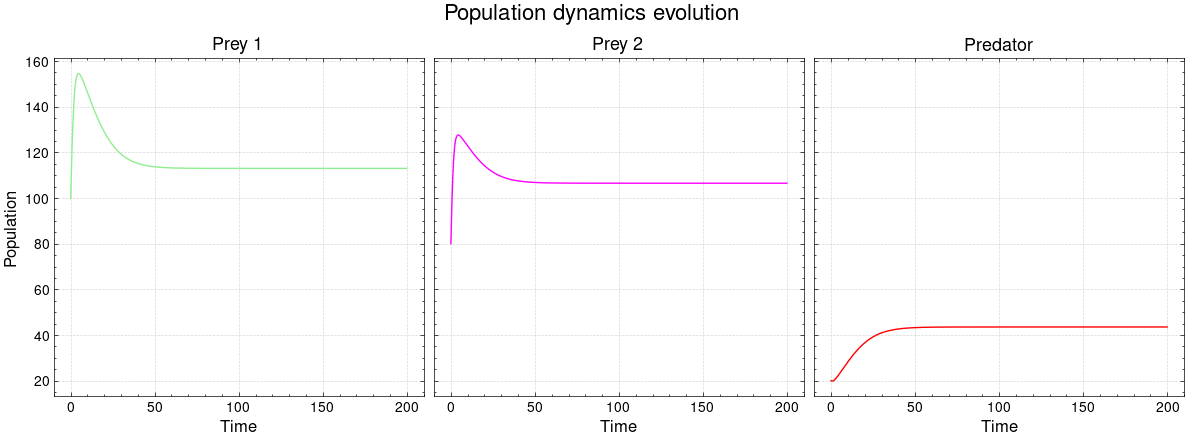

------------------------------------------------
METHOD: RK3
------------------------------------------------
INFO:
Time: 0.52 seconds
Number of steps: 20001
Equilibrium reached: True
------------------------------------------------
RESULTS:


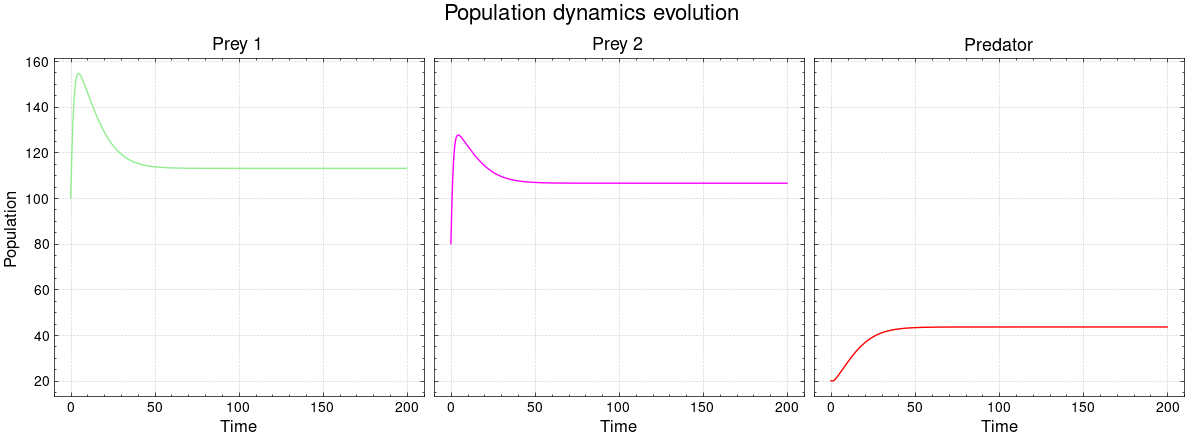

------------------------------------------------
METHOD: ASBUTCHER
------------------------------------------------
INFO:
Time: 0.03 seconds
Number of steps: 126
Equilibrium reached: True
------------------------------------------------
RESULTS:


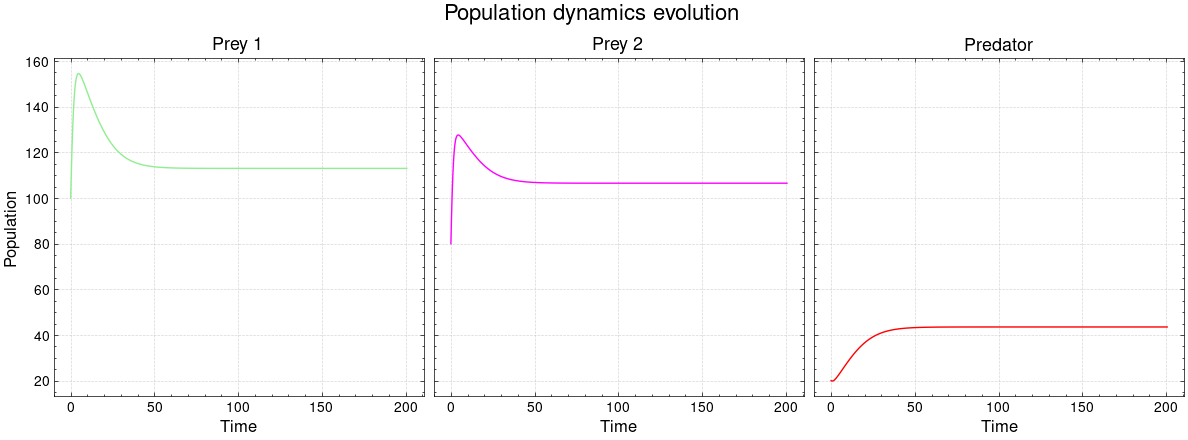

------------------------------------------------
Simulation finished.
------------------------------------------------


In [12]:
# Define all methods
methods = ['TRAPEZOIDAL', 'RK3', 'ASBUTCHER']

# Start 
print("------------------------------------------------")
print("Starting simulation...")

# Loop over all methods
for method in methods:

    # Print the method
    print(f"------------------------------------------------")
    print(f"METHOD: {method}")
    print(f"------------------------------------------------")

    # Copy the parameters
    params = default_params.copy()

    # Set the method
    params['method'] = method

    # --------------- Integration ---------------

    # Start the timer
    start = time.time()

    # Integrate the system
    t, S = integrator(params)

    # Stop the timer
    end = time.time()

    # ------------------- Info -------------------

    print(f"INFO:")

    # Time and number of steps
    print(f"Time: {end - start:.2f} seconds")
    print(f"Number of steps: {len(t)}")

    # We use the last ten points to check for equilibrium
    equilibrium = np.all(np.isclose(S[-10:], S[-1], atol = 1e-6))

    print(f"Equilibrium reached: {equilibrium}")

    print(f"------------------------------------------------")

    # ----------------- Plotting -----------------

    print(f"RESULTS:")
    plot_results(t, S)

# End
print("------------------------------------------------")
print("Simulation finished.")
print("------------------------------------------------")

They all do seem to reach equilibrim. Our RK3 method appears to be working well, but we still have to see if its error is actually of third order (Spoiler alert: it is).

#### On the adaptive step size results

As seen above, our Butcher's RK method is way more efficient than the other two methods (approximately $10$ times faster than trapezoidal!), while **still providing a higher accuracy**. The implementation has been successful.

Since the step change is not apparent with `plt.plot()`, we'll do an additional scatter plot below.

In [13]:
# Copy the parameters
as_params = default_params.copy()

# Set the method
as_params['method'] = 'ASBUTCHER'

# Integrate
t, S = integrator(as_params)

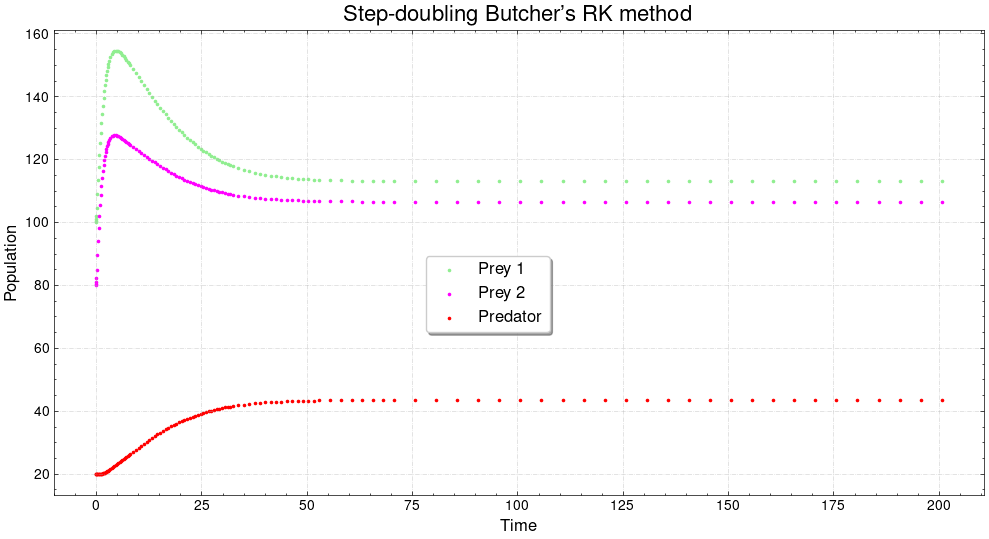

In [14]:
# Plot
plt.figure(figsize=(10, 5.5))

plt.scatter(t, S[:, 0], color="lightgreen", label = 'Prey 1', marker = '.', s = 10)
plt.scatter(t, S[:, 1], color="magenta", label = 'Prey 2', marker = '.', s = 10)
plt.scatter(t, S[:, 2], color="red", label = 'Predator', marker = '.', s = 10)

plt.title('Step-doubling Butcher\'s RK method', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.grid(True, ls='-.', alpha=0.5)
plt.legend(frameon=True, loc= (0.4,0.35), shadow=True, fontsize=12)
plt.tick_params(axis='both', labelsize=10)
plt.tight_layout()
plt.show()

The step size is smaller where accuracy is actually needed, and larger in "flat terrain" where the solution does not change much.

## 2. Dynamical systems and equilibrium (5 points)

### Python class:

#### **(a)** Reorganise all your code from problem 1 into a single python class that contains attributes and methods. The settings and initial conditions should be attributes and all the python functions should become methods. Add a method to compute $L_2$-norm errors.

All integration methods are going to be set as **private**. They should only be accessed through the public method `integrator()`. 

**Note**: In order to do the fixed-step analysis, I'm also going to add the normal Butcher's RK method.

In [15]:
# Class implementation
class PopulationPredictor:
    """
    Predict the population dynamics of two prey species and one predator species.
    """
    def __init__(self, params: dict = None):
        """
        Parameters
        ----------
        params : dict
            The system parameters.
        """
        # If no dictionary is given, set a default one
        if params is None:
            params = {
            'g1': 1.0,
            'c1': 200.0,
            'p1': 0.01,
            'g2': 1.2,
            'c2': 150.0,
            'p2': 0.008,
            'e1': 0.08,
            'e2': 0.07,
            'd': 0.15,
            'x0': 100.0,
            'y0': 80.0,
            'z0': 20.0,
            't_span': (0, 200),
            'dt': 0.01,
            'method': 'RK3'
            }

        # --------------- Extraction ---------------

        # Parameters
        self.g1 = params['g1']
        self.p1 = params['p1']
        self.c1 = params['c1']
        self.c2 = params['c2']
        self.g2 = params['g2']
        self.p2 = params['p2']
        self.e1 = params['e1']
        self.e2 = params['e2']
        self.d  = params['d']

        # Initial conditions
        self.x0 = params['x0']
        self.y0 = params['y0']
        self.z0 = params['z0']

        # Time
        self.t_span = params['t_span']
        self.dt     = params['dt']

        # Method
        self.method = params['method']

        # ------------- Initializations -------------

        # Time array
        t0, tf = self.t_span
        self.steps = int((tf - t0)/self.dt)
        self.t = np.linspace(t0, tf, self.steps + 1)

        # State array
        self.S = np.zeros((self.steps + 1, 3))
        self.S[0] = np.array([self.x0, self.y0, self.z0])

    #################################################
    #                 Public methods                #
    #################################################
    
    def integrator(self, method: str = None) -> tuple[np.ndarray, np.ndarray]:
        """
        Integrates the system based on the given parameters.

        Parameters
        ----------
        method : str
            The method to use.

        Returns
        -------
        np.ndarray
            The time vector.
        np.ndarray  
            The state vector.
        """
        # If no method is given
        if method is None:
            method = self.method

        # Integrate
        if method == 'RK3':
            t, S = self._rk3()

        elif method == 'TRAPEZOIDAL':
            t, S = self._trapezoidal()

        elif method == 'BUTCHER':
            t, S = self._butcher()

        elif method == 'ASBUTCHER':
            t, S = self._adaptive_butcher()

        else:
            warnings.warn(f"Method {method} is not available. Setting to RK3...")
            t, S = self._rk3()
        
        return t, S
    
    def see_evolution(self, 
                      t: np.ndarray = None,
                      S: np.ndarray = None,
                      show: bool = True,
                      other_info: str = None,
                      save: bool = False,
                      image_name: str = None)-> None:
        """
        Plot the evolution of the populations.

        Parameters
        ----------
        t : np.ndarray
            The time vector.
        S : np.ndarray
            The state vector.
        show : bool
            If True, show the image.
        other_info : str
            Additional information to be added to the title.
        save : bool
            If True, save the image.
        image_name : str
            The name of the image. Required if save is True.
        """
        # Call the integrator if no solution is given
        if t is None and S is None:
            t, S = self.integrator()

        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True)

        plt.suptitle(f'Population dynamics evolution{other_info}', fontsize=16)

        # Plot the results
        ax[0].plot(t, S[:, 0], color="lightgreen")
        ax[1].plot(t, S[:, 1], color="magenta")
        ax[2].plot(t, S[:, 2], color="red")

        # Labels
        ax[0].set_xlabel('Time', fontsize=12)
        ax[0].set_ylabel('Population', fontsize=12)
        ax[1].set_xlabel('Time', fontsize=12)
        ax[2].set_xlabel('Time', fontsize=12)

        ax[1].tick_params(axis='y', labelleft=False)
        ax[2].tick_params(axis='y', labelleft=False)

        ax[0].tick_params(axis='both', labelsize=10)
        ax[1].tick_params(axis='both', labelsize=10)
        ax[2].tick_params(axis='both', labelsize=10)

        # Titles
        ax[0].set_title('Prey 1', fontsize=13)
        ax[1].set_title('Prey 2', fontsize=13)
        ax[2].set_title('Predator', fontsize=13)

        # Grid
        ax[0].grid(True, ls='--')
        ax[1].grid(True, ls='--')
        ax[2].grid(True, ls='--')

        plt.subplots_adjust(wspace=0.0)

        ax[0].set_xlim(0, 210)
        ax[1].set_xlim(0, 210)
        ax[2].set_xlim(0, 210)
        ax[0].set_ylim(-10, 210)
        ax[1].set_ylim(-10, 210)
        ax[2].set_ylim(-10, 210)

        plt.tight_layout()

        if save:
            if image_name is None:
                raise ValueError("If save is True, image_name must be given.")
            plt.savefig(image_name, dpi = 200, bbox_inches='tight')

        if show:
            plt.show()

        plt.close(fig)

    def euclidean_error(self) -> float:
        """
        Computes the mean Euclidean norm error between the numerical 
        and "exact" solution across all time steps.
        
        Returns
        -------
        float
            The L2 error.
        """
        # Our solution
        _, S = self.integrator()

        # Exact solution
        _, S_exact = self._exact_solution()

        # Compute the error
        norm = np.sqrt(np.mean((S - S_exact)**2))

        return norm
    
    #################################################
    #                Private methods                #
    #################################################
    
    def _slope(self,
               t: float,
               S: np.ndarray) -> np.ndarray:
        """
        ODE slope function.

        Parameters
        ----------
        t : float
            The time (not used).
        s : np.ndarray
            State vector, [x y z].

        Returns
        -------
        np.ndarray
            The slope of the system.
        """
        # Get the state variables
        x, y, z = S

        # Compute the slope
        dx_dt = self.g1*x*(1 - x/self.c1) - self.p1*x*z
        dy_dt = self.g2*y*(1 - y/self.c2) - self.p2*y*z
        dz_dt = self.e1*self.p1*x*z + self.e2*self.p2*y*z - self.d*z

        return np.array([dx_dt, dy_dt, dz_dt])
    
    def _trapezoidal(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Trapezoidal method.

        Returns
        -------
        np.ndarray
            The time vector.
        np.ndarray
            The state vector."
        """ 
        # Integrate
        for i in range(0, self.steps):
            
            # Compute the slopes
            k1 = self._slope(self.t[i], self.S[i])
            k2 = self._slope(self.t[i] + self.dt, self.S[i] + self.dt*k1)

            # Update the state vector
            self.S[i + 1] = self.S[i] + self.dt*(k1 + k2)/2

        return self.t, self.S
    
    def _rk3(self) -> tuple[np.ndarray, np.ndarray]:
        """
        My third-order Runge-Kutta method.

        Returns
        -------
        np.ndarray
            The time vector.
        np.ndarray
            The state vector.
        """
        # Integrate
        for i in range(0, self.steps):
            
            # Compute the slopes
            k1 = self._slope(self.t[i], self.S[i])
            k2 = self._slope(self.t[i] + self.dt*c1, self.S[i] + self.dt*a10*k1)
            k3 = self._slope(self.t[i] + self.dt*c2, self.S[i] + self.dt*(a20*k1 + a21*k2))

            # Update the state vector
            self.S[i + 1] = self.S[i] + self.dt*(b0*k1 + b1*k2 + b2*k3)

        return self.t, self.S
    
    def _butcher(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Normal Butcher's RK method.

        Returns
        -------
        np.ndarray
            The time vector.
        np.ndarray
            The state vector.
        """
        # Integrate
        for i in range(0, self.steps):
            
            # Compute the slopes
            k1 = self._slope(self.t[i], self.S[i])
            k2 = self._slope(self.t[i] + self.dt/4, self.S[i] + (self.dt/4) * k1)
            k3 = self._slope(self.t[i] + self.dt/4, self.S[i] + (self.dt/8) * k1 + (self.dt/8) * k2)
            k4 = self._slope(self.t[i] + self.dt/2, self.S[i] - (self.dt/2) * k2 + self.dt * k3)
            k5 = self._slope(self.t[i] + 3*self.dt/4, self.S[i] + (3*self.dt/16) * k1 + (9*self.dt/16) * k4)
            k6 = self._slope(self.t[i] + self.dt, self.S[i] - (3*self.dt/7) * k1 + (2*self.dt/7) * k2 + (12*self.dt/7) * k3 - (12*self.dt/7) * k4 + (8*self.dt/7) * k5)
            
            # Update the state vector
            self.S[i + 1] = self.S[i] + self.dt/90 * (7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)

        return self.t, self.S
    
    def _adaptive_butcher(self, 
                          tol: float = 1e-6) -> tuple[np.ndarray, np.ndarray]:
        """
        Adaptive-step-size Butcher's Runge-Kutta method.

        Parameters
        ----------
        tol : float, optional
            The tolerance for the error. The default is 1e-6.

        Returns
        -------
        np.ndarray
            The time vector.
        np.ndarray
            The state vector.
        """
        # Initialize the time and state vectors
        t = [self.t_span[0]]
        S = [self.S[0]]

        # Set initial step size
        h = self.dt

        # Integrate the system
        while t[-1] < self.t_span[1]:

            # Try a full step
            s_full = self._butcher_step(t[-1], S[-1], h)

            # Try two half steps
            s_half = self._butcher_step(t[-1], S[-1], h/2)
            s_half = self._butcher_step(t[-1] + h/2, s_half, h/2)
            
            # Compute the error between decisions
            error = np.linalg.norm(s_full - s_half)
            
            # Step size control
            if error < tol:
                
                # Accept the step
                S.append(s_half)
                t.append(t[-1] + h)

                # Increase the step size if error is small
                if error < tol/5:
                    h *= 2.0

                # Avoid too large steps
                if h > 5.0:
                    h = 5.0

            else: 
                # Reduce the step size and try again
                h *= 0.5

                # Avoid too small steps
                if h < 1e-3:
                    h = 1e-3

        return np.array(t), np.array(S)
    
    def _butcher_step(self,
                      t_curr: float,
                      s_curr: np.ndarray,
                      step: float) -> np.ndarray:
        """
        Next point using the Butcher's RK method.

        Parameters
        ----------
        t_curr : float
            The current time.
        s_curr : np.ndarray
            The current state.
        step : float
            The step size.

        Returns
        -------
        np.ndarray
            The next state.
        """
        # Compute the slopes
        k1 = self._slope(t_curr, s_curr)
        k2 = self._slope(t_curr + step/4, s_curr + (step/4) * k1)
        k3 = self._slope(t_curr + step/4, s_curr + (step/8) * k1 + (step/8) * k2)
        k4 = self._slope(t_curr + step/2, s_curr - (step/2) * k2 + step * k3)
        k5 = self._slope(t_curr + 3*step/4, s_curr + (3*step/16) * k1 + (9*step/16) * k4)
        k6 = self._slope(t_curr + step, s_curr - (3*step/7) * k1 + (2*step/7) * k2 + (12*step/7) * k3 - (12*step/7) * k4 + (8*step/7) * k5)
        
        return s_curr + step/90 * (7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)

    def _exact_solution(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Approximates exact solution using RK45
        with high accuracy settings.

        Returns
        -------
        np.ndarray
            The time vector.
        np.ndarray
            The state vector.
        """
        # Solve the system
        sol = solve_ivp(self._slope, self.t_span, self.S[0], method = "RK45",
                        t_eval = self.t, rtol = 1e-13, atol = 1e-13)

        return sol.t, sol.y.T

### Error analysis:

#### **(b)** Call the methods from your python class above to run $15$ simulations ($5$ simulations per integration method) for $5$ decreasing values of the time step size, `dt` (i.e. $h$). Then, compute the $L_2$-norm errors for all these $15$ runs and report the results in a single figure with the $L_2$-norm errors in the Y axis and $h$ in the X axis. Which method produces the most accurate results?


In [16]:
# Little function
def get_errors(h_array, method, parameters = default_params):
    """
    Computes the errors for the given step sizes.

    Parameters
    ----------
    h_array : np.ndarray
        The step sizes.
    method : str
        The method to use.
    parameters : dict
        The system parameters. Set to default ones.

    Returns
    -------
    np.ndarray
        The errors.
    """
    # List
    errors = []

    # Loop over all step sizes
    for h in h_array:

        # Copy the parameters
        params = parameters.copy()

        # Set the step size and method
        params['dt'] = h
        params['method'] = method

        # Initialize the predictor
        predictor = PopulationPredictor(params)

        # Compute the error
        error = predictor.euclidean_error()

        # Store the error
        errors.append(error)

    return np.array(errors)

In [17]:
# Define the step sizes (big ones)
h_array = np.array([1, 0.5, 0.25, 0.1, 0.05])

In [18]:
# Get all the errors
err_trp = get_errors(h_array, 'TRAPEZOIDAL')
err_rk3 = get_errors(h_array, 'RK3')
err_but = get_errors(h_array, 'BUTCHER')

# Take the log of each
log_h = np.log(h_array)
log_trapezoidal = np.log(err_trp)
log_rk3 = np.log(err_rk3)
log_butcher = np.log(err_but)

# And find the slopes
slope_trp = np.polyfit(log_h, log_trapezoidal, 1)[0]
slope_rk3 = np.polyfit(log_h, log_rk3, 1)[0]
slope_but = np.polyfit(log_h, log_butcher, 1)[0]

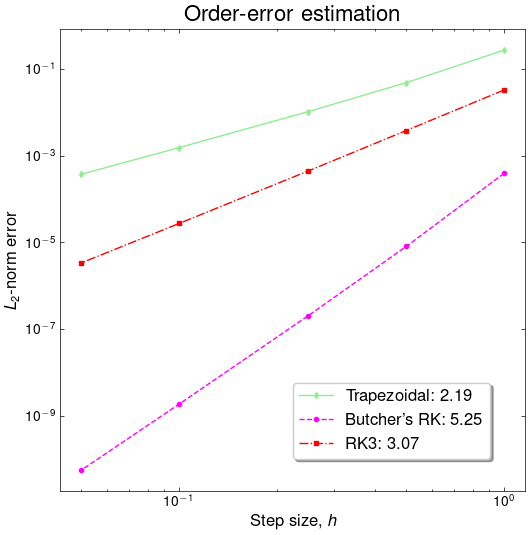

In [19]:
# Plot the results
plt.figure(figsize=(6, 6))

plt.plot(h_array, err_trp, c = "lightgreen", marker = 'd', label = f"Trapezoidal: {slope_trp:.2f}")
plt.plot(h_array, err_but, marker = 'o',c = "magenta", label = f"Butcher's RK: {slope_but:.2f}")
plt.plot(h_array, err_rk3, c = "r", marker = 's', label = f"RK3: {slope_rk3:.2f}")

plt.loglog()

plt.xlabel(r"Step size, $h$", fontsize = 12)
plt.ylabel(r"$L_2$-norm error", fontsize = 12)
plt.title("Order-error estimation", fontsize = 16)

plt.legend(frameon = True, shadow = True, fontsize = 12, loc = (0.5,0.07))
plt.tick_params(axis='both', labelsize=10)
plt.show()

All method slopes align well with the expected values. Now we can confidently say that our RK3 implementation was successful.

Answering the question, **it's Butcher's RK the one that produces the most accurate results (also expected)**. 


### Equilibrium conditions:

#### **(c)** Write down the equilibrium condition for the system, $S(t)$. Then, create a python function that uses `sympy` to study the equilibrium populations of $x$, $y$, and $z$ for a range of values of the natural death rate of the predator, $d$. The function should accept a range of $d$ values and return the equilibrium populations for all the $d$ values in the range. Ensure that the solutions are filtered to exclude extinction cases.



In dynamical systems, the equilibrium points, also known as *fixed points*, are the ones where **the populations remain constant over time**. Mathematically, this is represented by
$$
\frac{dS}{dt} = \textbf{0}.
$$
In our case:

\begin{aligned}
\begin{bmatrix}
\displaystyle\frac{dx}{dt} \\[1em]
\displaystyle\frac{dy}{dt} \\[1em]
\displaystyle\frac{dz}{dt}
\end{bmatrix} = \begin{bmatrix}
g_1\,x \left( 1 - \displaystyle\frac{x}{c_1} \right) - p_1\,x\,z \\[1em]
g_2\,y \left( 1 - \displaystyle\frac{y}{c_2} \right) - p_2\,y\,z \\[1em]
e_1\,p_1\,x\,z + e_2\,p_2\,y\,z - d\,z
\end{bmatrix} = \textbf{0}.
\end{aligned}

In [20]:
# Define the symbolic variables once only
x, y, z = sp.symbols('x y z')

# Predator death rate array
d_array = np.linspace(0.01, 1.0, 100)

In [21]:
# Another little function
def equilibrium_points(d_array, params = default_params):
    """
    Computes the equilibrium points for the given parameters.

    Parameters
    ----------
    d_array : np.ndarray
        The predator death rates.
    params : dict
        The system parameters.

    Returns
    -------
    np.ndarray
        The equilibrium points.
    np.ndarray
        The valid d values, i.e. no extintion or negative populations.
    """
    # Extract the parameters
    g1 = params['g1']
    c1 = params['c1']
    p1 = params['p1']
    g2 = params['g2']
    c2 = params['c2']
    p2 = params['p2']
    e1 = params['e1']
    e2 = params['e2']

    # Define the equations that do not depend on d
    eq1 = g1*x*(1 - x/c1) - p1*x*z
    eq2 = g2*y*(1 - y/c2) - p2*y*z

    # Empty lists for the equilibrium and valid d points
    eq_points = []
    d_valid = []

    # Start
    print("-----------------------------------------------")
    print("Computing equilibrium points...")
    print("-----------------------------------------------")

    # Loop over all d-values
    for d in d_array:

        # Third equation
        eq3 = e1*p1*x*z + e2*p2*y*z - d*z

        # Solve the system and store in a dictionary
        sol = sp.solve([eq1, eq2, eq3], (x, y, z), dict = True)

        # Filter only positive and non-zero solutions
        sol = [s for s in sol if all(v > 0 for v in s.values())]

        # Avoid empty solutions
        if not sol:
            continue

        # Append
        eq_points.append(sol)
        d_valid.append(d)

        # Print progress
        if len(eq_points) % 5 == 0:
            print(f"Processed {len(eq_points)} valid d values.")

    # Extract and convert to array
    eq_points = np.array([[s[0][x], s[0][y], s[0][z]] for s in eq_points])
    d_valid = np.array(d_valid)

    # End and other info
    print("-----------------------------------------------")
    print("Finished computing!")
    print("-----------------------------------------------")
    print("INFO:")
    print(f"# of equilibrium points found: {len(eq_points)}.")
    print(f"Valid d-range: [{d_valid[0]:.2f}, {d_valid[-1]:.2f}].")
    print("-----------------------------------------------")

    return eq_points, d_valid

In [22]:
# Compute
eq_points, d_points = equilibrium_points(d_array)

-----------------------------------------------
Computing equilibrium points...
-----------------------------------------------
Processed 5 valid d values.
Processed 10 valid d values.
Processed 15 valid d values.
Processed 20 valid d values.
-----------------------------------------------
Finished computing!
-----------------------------------------------
INFO:
# of equilibrium points found: 22.
Valid d-range: [0.03, 0.24].
-----------------------------------------------


#### **(d)** After computing equilibrium solutions for multiple values of the predator mortality $d$, you should create a high-quality figure of the equilibrium populations of $x$, $y$, and $z$ (on the Y axis) versus $d$ (on the x-axis), and label what happens in the parameter regions outside of equilibrium conditions.


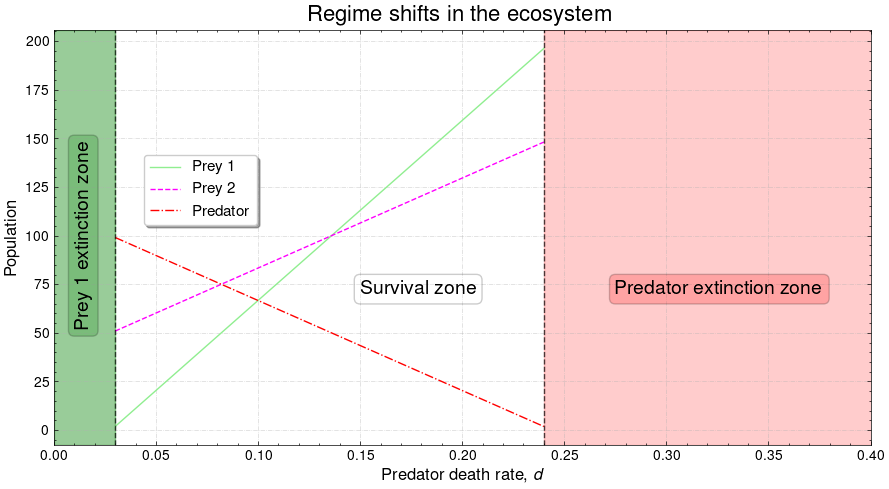

In [23]:
# ------------- Equilibrium --------------
plt.figure(figsize = (9, 5))

# Population vs death rate
plt.plot(d_points, eq_points[:, 0], c = "lightgreen", label = "Prey 1")
plt.plot(d_points, eq_points[:, 1], c = "magenta", label = "Prey 2")
plt.plot(d_points, eq_points[:, 2], c = "r", label = "Predator")

# Title and labels
plt.title("Regime shifts in the ecosystem", fontsize = 16)
plt.xlabel(r"Predator death rate, $d$", fontsize = 12)
plt.ylabel("Population", fontsize = 12)

# -------------- Extinction zones --------------
plt.axvspan(0.24, 0.5, alpha = 0.2, color='r')
plt.axvspan(0.00, 0.03, alpha = 0.4, color='g')

# Limit lines
plt.axvline(x = 0.24, color='k', linestyle='--', alpha=0.7, lw = 1)
plt.axvline(x = 0.03, color='k', linestyle='--', alpha=0.7, lw = 1)

# ----------------- Text boxes -----------------
plt.text(x = 0.275, y = 70, s = 'Predator extinction zone', fontsize = 14,
         bbox=dict(facecolor = 'r', alpha = 0.2, boxstyle='round'))

plt.text(x = 0.15, y = 70, s = 'Survival zone', fontsize = 14,
         bbox=dict(facecolor = 'w', alpha = 0.2, boxstyle='round'))

plt.text(x = 0.01, y = 100, s = 'Prey 1 extinction zone', fontsize = 14,
         rotation = 90, va = 'center', bbox=dict(facecolor = 'g', alpha = 0.2, boxstyle='round'))


plt.legend(frameon = True, shadow = True, fontsize = 11, loc = (0.11,0.53))
plt.tick_params(axis='both', labelsize=10)
plt.xlim(0, 0.40)
plt.grid(ls='-.', alpha = 0.5)
plt.tight_layout()
plt.show()

Outside of the specific range of predator death rate ($d$) found above, one of the three populations goes extinct. Specifically, when $d>0.24$, the predator population goes extinct, and when $d<0.03$, the prey $1$ one does. 

---

**Why is it prey $1$ the one that goes extinct?**

The parameters determine which prey population goes extinct. This can be seen by looking at the first two equations and some of the default parameters. Replacing such values in the equations yield

$$
\begin{aligned}
\frac{dx}{dt} &= x \left( 1 - \frac{x}{200} \right) - 0.01\,x\,z, \\
\frac{dy}{dt} &= 1.2\,y \left( 1 - \frac{y}{150} \right) - 0.008\,y\,z. \\
\end{aligned}
$$

Even though the carrying capacity of prey $1$ is larger than that of prey $2$, its growth rate is $25\%$ smaller and predation rate is $25\%$ larger than prey $2$. In the end, these two parameters end up dominating the evolution of the system, and that's why prey $1$ goes extinct.

---


#### **(e)** Based on your analysis, for what range of $d$ values the system reaches equilibrium? What happens outside of that range? Call your class again to run and compare equilibrium versus extinction scenarios using $3$ different values of $d$.


The system reaches equilibrium for (approximately) $d \in [0.03, 0.24]$, and outside of that range one of the three populations goes extinct. 

While I do think $3$ well-chosen $d$ values would be sufficient and instructive enough, I'm going to present a movie of the system evolution as $d$ changes.

In [24]:
# Some good d range that includes extinction and survival zones
d_array_2 = np.linspace(0, 0.26, 50)

In [25]:
# Copy the parameters
params = default_params.copy()

# Use the fastest and most efficient method
params['method'] = 'ASBUTCHER'

# Directory
if not os.path.exists("./d-output"):
    os.makedirs("./d-output")

In [26]:
# Start
print("-----------------------------------------------------")
print("Plotting evolutions...")
print("-----------------------------------------------------")

# Timer
start = time.time()

# Counter
counter = 0

# Loop over all d values
for d in d_array_2:

    # Set the death rate
    params['d'] = d

    # Instantiate the predictor
    predictor = PopulationPredictor(params)

    # Save the evolution
    predictor.see_evolution(save = True, image_name = f"./d-output/evolution-{d:.3f}.png",
                            other_info = f": d = {d:.3f}", show = False)
    
    # Update the counter
    counter += 1

    # Print progress
    if counter % 5 == 0:
        print(f"Done {counter} plots.")

# Stop the timer
end = time.time()

# End
print("-----------------------------------------------------")
print("Finished plotting! All saved in ./d-output")
print("-----------------------------------------------------")
print("INFO:")
print(f"# of plots: {counter}.")
print(f"Method: {params['method']}.")
print(f"Total time: {end - start:.2f} seconds")
print("-----------------------------------------------------")

-----------------------------------------------------
Plotting evolutions...
-----------------------------------------------------
Done 5 plots.
Done 10 plots.
Done 15 plots.
Done 20 plots.
Done 25 plots.
Done 30 plots.
Done 35 plots.
Done 40 plots.
Done 45 plots.
Done 50 plots.
-----------------------------------------------------
Finished plotting! All saved in ./d-output
-----------------------------------------------------
INFO:
# of plots: 50.
Method: ASBUTCHER.
Total time: 66.06 seconds
-----------------------------------------------------


In [27]:
# Sort
images = sorted(glob.glob("./d-output/*.png"),
                key=lambda x: float(x.split('evolution')[-1].split('.png')[0]),
                reverse = True)

# List to store the images
frames = []

# Load all images
for img in images:
    frames.append(Image.open(img))

# Save the gif
gif_path = "./d-output/evolution.gif"
frames[0].save(gif_path, format='GIF', append_images = frames[1:],
               save_all = True, duration = 100, loop = 0)

In [28]:
# Let's see it
# display(IPImage(gif_path))

Now we can clearly see the extinction of the predator population when $d$ exceeds $0.24$, and the extinction of prey $1$ when $d$ is smaller than $0.03$.

#### Phase space visualization

I wanted to *see* how different initial conditions converge to the same equilibrium point, and this can be done in phase space. In this case, $d=0.15$ and we varied the initial populations of the three species.

In [29]:
# Different intial conditions
populations = np.array([[100, 80, 20],
                        [80, 100, 40],
                        [110, 90, 30],
                        [90, 110, 50],
                        [70, 60, 60]])

# Empty list
solutions = []

# Loop over all populations
for s0 in populations:

    # Set the initial conditions
    params['x0'] = s0[0]
    params['y0'] = s0[1]
    params['z0'] = s0[2]

    # Integrate the system
    t, S = integrator(params)

    # Append the solution
    solutions.append(S)

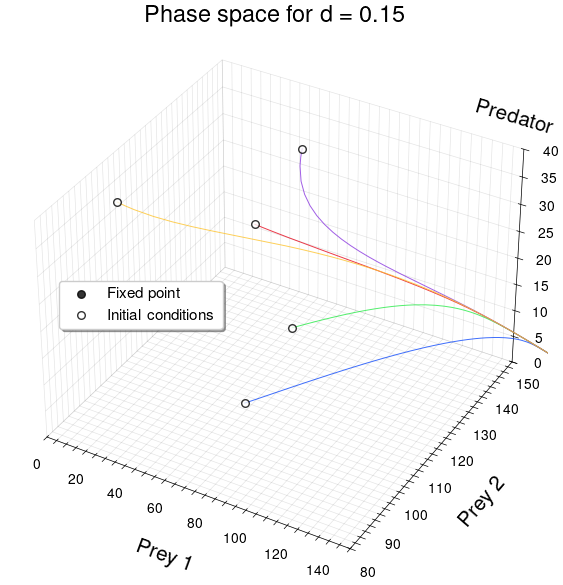

In [30]:
# Plot
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(111, projection='3d')

# Title and labels
ax.set_title(f'Phase space for d = {default_params["d"]}', fontsize = 17)

ax.set_xlabel('Prey 1', fontsize=15, labelpad=12)
ax.set_ylabel('Prey 2', fontsize=15, labelpad=12)
ax.text(145, 150, 45, 'Predator', 'x', fontsize=15, 
        horizontalalignment='center', verticalalignment='center')

# Solutions
for S in solutions:
    ax.plot(S[:, 0], S[:, 1], S[:, 2], alpha = 0.8, lw = 0.7, ls = '-')

# Equilibrium point (we simply take one)
ax.scatter(S[-1, 0], S[-1, 1], S[-1, 2], color='black', marker='o', s = 30,
           label = 'Fixed point', alpha=0.8)

# All initial conditions but the last one
for s0 in populations[:-1]:
    ax.scatter(s0[0], s0[1], s0[2], edgecolor='k', facecolor='white', 
               linewidths = 1, s = 30, alpha=0.8)
    
# Last initial condition (to add one label only)
ax.scatter(populations[-1][0], populations[-1][1], 
           populations[-1][2], edgecolor='k', facecolor='white', 
           linewidths = 1, s = 30, alpha=0.8, label = 'Initial conditions')

# Edges
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.set_alpha(0.0)
ax.yaxis.pane.set_alpha(0.0)
ax.zaxis.pane.set_alpha(0.0)

# Grid
ax.xaxis._axinfo["grid"]["color"] = (0, 0, 0, 0.1)
ax.yaxis._axinfo["grid"]["color"] = (0, 0, 0, 0.1)
ax.zaxis._axinfo["grid"]["color"] = (0, 0, 0, 0.1)
ax.xaxis._axinfo["grid"]["linewidth"] = 0.5
ax.yaxis._axinfo["grid"]["linewidth"] = 0.5
ax.zaxis._axinfo["grid"]["linewidth"] = 0.5

ax.set_xlim(0, 150)
ax.set_ylim(80, 150)
ax.set_zlim(0, 40)

ax.legend(loc=(0.10, 0.45), fontsize=11, frameon = True, shadow = True)
ax.tick_params(axis='both', labelsize=10)

ax.view_init(roll=0, elev = 35)
plt.show()

It looks great :)! 

## 3. Quantum Harmonic Oscillator (7 points)


The Schrödinger equation for the quantum harmonic oscillator is:

$$-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2}+\frac{1}{2}m\omega^2x^2\psi=E\psi$$

It can be rewritten, in terms of a new variable, $\xi\equiv\sqrt{\frac{m\,\omega}{\hbar}}x$, as follows:

$$\frac{d^2\psi}{d\xi^2}=\left(\xi^2 -K\right)\psi$$

where $K\equiv\frac{2E}{\hbar\omega}$ is the energy in units of $\frac{1}{2}\hbar\omega$.

### Order reduction and slope function:

#### **(a)** Reduce the above ODE to first order. Write down the resulting slope function.

Since the ODE is of second order and linear, it can reduced it to a system of two first-order ODEs. We do this by introducing the state vector $S=[\psi, \dot{\psi}]^{\top}$, where $\dot{\psi} = \frac{d\psi}{d\xi}$. Then we can write the system as

$$
\frac{dS}{d\xi} = \begin{bmatrix}
\displaystyle\dot{\psi} \\[0.5em]
\displaystyle\ddot{\psi}
\end{bmatrix} = \underbrace{\begin{bmatrix}
0 & 1 \\[0.5em]
\xi^2 - K & 0
\end{bmatrix} \begin{bmatrix}
\psi\\[0.5em]
\dot{\psi}
\end{bmatrix}}_{\text{Slope function, }F(S)},
$$

which allows us to solve it numerically.

### Shooting method class:

#### **(b)** Carefully read the tasks (c-g) below and design a suitable python class with attributes and methods that solves the above ODE using **the shooting method** with the slope computed in (a). You may use scipy integrators; there is no need to design your own integrators in this problem.

In [31]:
# Implementation
class QuantumHarmonicSolver:
    """
    Solves the quantum harmonic oscillator numerically.
    """
    def __init__(self, params: dict = None):
        """
        Parameters
        ----------
        params : dict
            The system parameters.
        """
        # If no dictionary is given
        if params is None:
            params = {
                'parity': 'odd',
                'xi_span': (-5, 5),
                'dxi': 0.01,
                'K': 1.0
                }
            
        # --------------- Extraction ---------------
        
        # Parity
        self.parity = params['parity']

        # Displacement
        self.xi_span = params['xi_span']
        self.dxi = params['dxi']

        # Eigenvalue guess
        self.K = params['K']

        # ------------- Initializations ------------

        # Displacement array
        xi0, xif = self.xi_span
        self.steps = int((xif - xi0)/self.dxi)
        self.xi = np.linspace(xi0, xif, self.steps + 1)

        # Use parity to determine problem
        if self.parity == 'even':
            self.psi0 = 1
            self.dpsi0 = 0

        elif self.parity == 'odd':
            self.psi0 = 0
            self.dpsi0 = 1

        else:
            raise ValueError("Parity must be either 'even' or 'odd'.")
        
        # State vector  
        self.S = np.zeros((self.steps + 1, 2))
        self.S[0] = np.array([self.psi0, self.dpsi0])

        # Print info to the user
        print(self)

    # def _objective(self):
    #     """
    #     Objective function to minimize.
    #     """
    #     # Integrate the system
    #     xi, S = solve_ivp(self._slope, self.xi_span, self.S[0], method = "RK45",
    #                         t_eval = self.xi, rtol = 1e-13, atol = 1e-13).y

    #     return np.array([S[0], S[1]])

    # def _slope(self, xi, S) -> np.ndarray:
    #       """
    #       ODE slope function.
    #       """
    #       # Get the state variables
    #       psi, dpsi = S
    
    #       # Compute the slope
    #       d2psi_dxi2 = (xi**2 - self.K)*psi
    
    #       return np.array([dpsi, d2psi_dxi2])
    
    # def __str__(self):
    #     """
    #     Info about the boundary conditions.
    #     """
    #     return f"With {self.parity} parity, the boundary conditions are ψ(0) = {self.psi0} and ψ'(0) = {self.dpsi0}.\n" \
        

### Tasks to be performed by your python class:

#### **(c)** Find the **ground state energy** of the harmonic oscillator, to six significant digits, by using **the shooting method**. That is, solve the above equation numerically, varying $K$ until you get a wave function that goes to zero at large $\xi$. The appropriate boundary conditions for the ground state (and any even state) are $\psi(0) = 1$, $\psi'(0) = 0$.

#### **(d)** Make a few illustrative panels showing plots of the wave function for different values of $K$ as it converges to the solution. What does the tail of the wave function does when the values are slightly above or below the correct solution?

#### **(e)** Find the **first four excited state energies** (to six significant digits) for the harmonic oscillator, using **the shooting method**. For the first (and third) excited state you will need to set $\psi(0) = 0$, $\psi'(0) = 1$.


#### **(f)** Make a few illustrative panels showing plots of the wave functions for different values of $K$ as they converge to their respective solutions.

#### **(g)** Make a single plot showing the **harmonic potential** joinly with the **energy ladder** of the quantum harmonic oscillator (include the ground state plus the first four excited states that you calculated above, each with their **respective wave functions**). Consider the particle to be an electron and choose appropriate units for any physical parameters you may need.